In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random
from src.utils import create_2d_mask
from src.interpolate import *
from src.algorithm import conjugate_gradient

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon, iradon_sart
from tqdm import tqdm


In [460]:
def get_fwd_model(pts, rotate_and_project, mask, args = {}):
    
    @jax.jit
    def fwd_model(amp, theta):
        proj, _, _ = rotate_and_project(amp*mask, theta, pts, **args)
        return proj
    
    fwd_model_vmap = jax.jit(jax.vmap(fwd_model, in_axes = (None, 0)))
    
    return fwd_model, fwd_model_vmap

def get_loss_function(fwd_model):
    """Can pass either fwd_model or fwd_model_vmap, and thetas
    should be an array or one angle depending on the forward model."""
    
    @jax.jit
    def loss_func(amp, thetas, data): 
        err = fwd_model(amp, thetas) - data
        return 1/2 * jnp.sum(jnp.real(jnp.conj(err)*err)) / jnp.prod(jnp.array(err.shape))
    
    grad_loss_func = jax.jit(jax.grad(loss_func))
    
    return loss_func, grad_loss_func



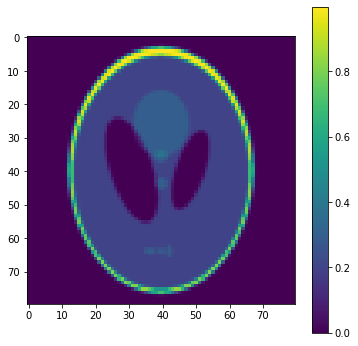

In [461]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.2, mode='reflect')

plt.imshow(image); plt.colorbar()

In [5]:
image.shape

(80, 80)

(80, 1000)


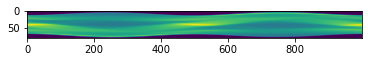

In [6]:
N = 1000 #image.shape[0]+2

thetas_deg = jnp.linspace(0, 360, N)
thetas = thetas_deg * jnp.pi/180

sinogram = radon(image, theta = thetas_deg)
print(sinogram.shape)
plt.imshow(sinogram)

### FBP

Error = 0.3870240021826725


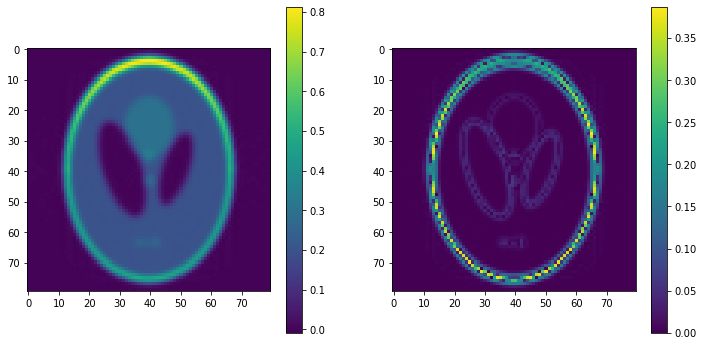

In [7]:
# The filter doesn't make a huge difference

rec_fbp = iradon(sinogram, theta=thetas_deg, filter_name='hann')
err_fbp = jnp.abs(rec_fbp - image)
print(f"Error = {jnp.max(err_fbp)}")

plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_fbp); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_fbp); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### SART

In [10]:
N_iter = 100

rec_sart = np.zeros(image.shape)

t0 = time.time()
for i in tqdm(range(N_iter)):
    rec_sart = iradon_sart(sinogram, theta=thetas_deg, image=rec_sart)
print(f"{time.time()-t0} seconds")
    
err_sart = jnp.abs(rec_sart - image)
print(f"Error = {jnp.max(err_sart)}")

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]

65.78088879585266 seconds
Error = 0.06412579780802383


In [205]:
rec_sart = rec_sart /jnp.max(rec_sart) * jnp.max(image)

In [206]:
print(f"Max error = {jnp.max(err_sart)}")
print(f"Mean error = {jnp.mean(err_sart)}")

Max error = 0.06412579780802383
Mean error = 0.007418742699833463


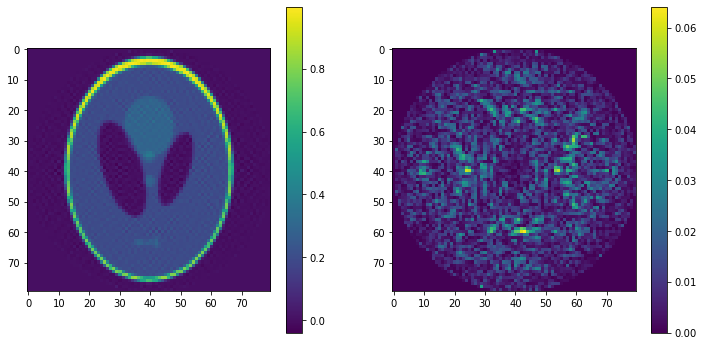

In [207]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_sart); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_sart); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### GMM

In [597]:
def gen_gauss_x(amp, centre, x, sig):
    return amp * jnp.exp(-(x-centre)**2/(2*sig**2))

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, 0, None,None))

def pts2img(amp, pts, x_grid, sig):
    p_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig)
    p_y = gen_gauss_x_vmap(jnp.ones(amp.shape), pts[:,1], x_grid, sig) 
    return jnp.matmul(p_x.transpose(), p_y).transpose() 

#pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)

def rotate_and_project_gmm(amp, theta, pts, x_grid, sig):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts = (R @ pts.transpose()).transpose()
    #img = pts2img(amp, pts, x_grid, sig)
    #proj = jnp.sum(img, axis=0)
    
    img = 0
    gaussians_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig) 
    proj = jnp.sum(gaussians_x, axis = 0)
    
    #print(gaussians_x.shape)
    return proj, img, pts


In [598]:
nx = image.shape[0]
x_grid = jnp.fft.fftshift(jnp.fft.fftfreq(nx))
sigma = 0.006
amp = 10 + jnp.array(np.random.randn(nx*nx))

rotate_and_project_args = {"x_grid" : x_grid, "sig" : sigma }

In [599]:
X, Y = jnp.meshgrid(x_grid, x_grid)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

In [600]:
grid_obj = np.array([x_grid[1]-x_grid[0], nx])
mask = jnp.fft.fftshift(create_2d_mask(grid_obj, (0,0), 0.49))

In [601]:
img = pts2img(amp, pts, x_grid, sigma)

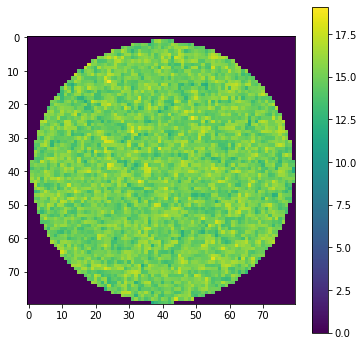

In [602]:
plt.imshow(img*mask); plt.colorbar()

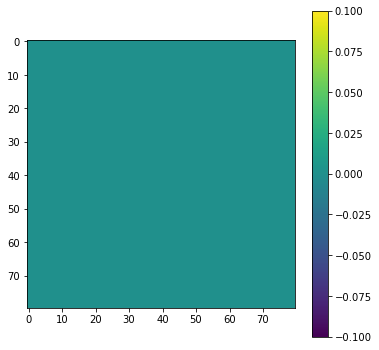

In [603]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project_gmm(amp, theta, pts, x_grid, sigma)
plt.imshow(mask*img_rot); plt.colorbar()

In [604]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_gmm, mask.ravel(), rotate_and_project_args)

N = sinogram.shape[1]
sig_noise = 1000

#thetas = jnp.linspace(0., 2*jnp.pi, N)

data = sinogram.transpose() #fwd_model_vmap(amp, thetas) 
data_noisy = data + np.random.randn(N, nx) * sig_noise

SNR = jnp.sum(data**2)/jnp.sum(data_noisy**2)
print(f"max(data) = {jnp.max(data)}")
print(f"SNR = {SNR}")

max(data) = 20.496754172294803
SNR = 0.00012403044871844192


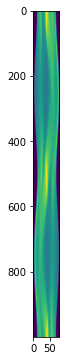

In [605]:
plt.imshow(data)

In [606]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap)

In [607]:
zero = jnp.zeros((nx**2,))
Ab = -grad_loss_func(zero, thetas, data)
AA = lambda v : grad_loss_func(v, thetas, data) + Ab

x0_cg = jnp.zeros(amp.shape)
N_iter = 100

x0_cg, cg_iters = conjugate_gradient(AA, Ab, x0_cg, N_iter, verbose=True)

  cg iter 0 ||r|| = 1.234610234998182
  cg iter 10 ||r|| = 0.022922393506549184
  cg iter 20 ||r|| = 0.004118076333309576
  cg iter 30 ||r|| = 0.0012361303469018224
  cg iter 40 ||r|| = 0.002164499592499668
  cg iter 50 ||r|| = 0.0005852398274784907
  cg iter 60 ||r|| = 0.0004494809574503244
  cg iter 70 ||r|| = 0.0003853822544843713
  cg iter 80 ||r|| = 0.00020450875283603318
  cg iter 90 ||r|| = 0.00025895511331846947


In [608]:
rec_gmm = pts2img(x0_cg, pts, x_grid, sigma)
rec_gmm = rec_gmm / jnp.max(rec_gmm) * jnp.max(image)

In [609]:
err_gmm = jnp.abs(rec_gmm - image)
print(f"Max error = {jnp.max(err_gmm)}")
print(f"Mean error = {jnp.mean(err_gmm)}")

Max error = 0.08970777544076391
Mean error = 0.008038246874150024


In [610]:
jnp.max(jnp.abs(grad_loss_func(x0_cg, thetas, data)))

DeviceArray(9.36538427e-06, dtype=float64)

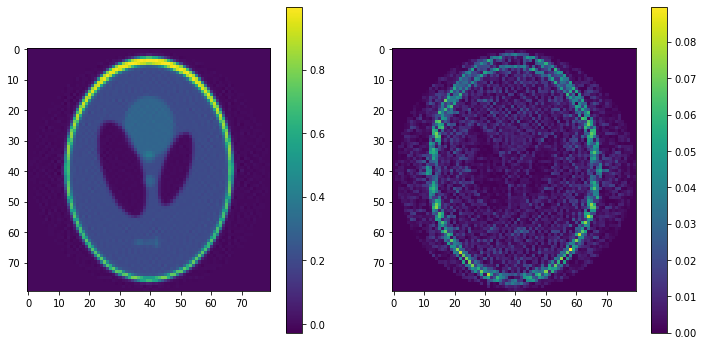

In [611]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm*mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm*mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [612]:
N_iters = 100
alpha = 1e-1

x0 = jnp.zeros(amp.shape)

for i in range(N_iters):
    grad = grad_loss_func(x0, thetas, data)
    if jnp.mod(i, 10) == 0:
        #err = jnp.abs(amp-x0).reshape([nx,nx]) * mask
        err = jnp.abs(grad)
        
        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad
    
rec_gmm = pts2img(x0, pts, x_grid, sigma)
err_gmm = jnp.abs(rec_gmm - image)
print(f"Error = {jnp.max(err_gmm)}")

11.80071472979178
3.3866172894578606
1.2644412447852458
0.7772109571646912
0.6140465010497591
0.5171968269359835
0.447313643533866
0.39391072686070083
0.35170372763471724
0.3174393068873953
Error = 0.48564078648885


In [613]:
jnp.max(image)

DeviceArray(0.99821456, dtype=float64)

In [614]:
rec_gmm = pts2img(x0, pts, x_grid, sigma)
err_gmm = jnp.abs(rec_gmm - image)
print(f"Error = {jnp.max(err_gmm)}")
jnp.max(jnp.abs(grad_loss_func(x0, thetas, data)))

Error = 0.48564078648885


DeviceArray(0.01657738, dtype=float64)

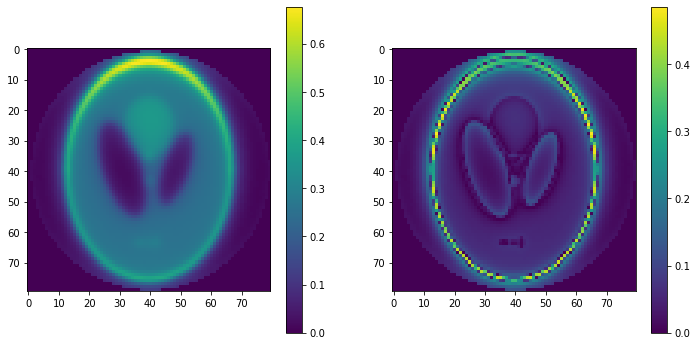

In [615]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm*mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm*mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [616]:
print(loss_func(x0_cg, thetas, data))
print(loss_func(x0, thetas, data))

print(jnp.max(jnp.abs(grad_loss_func(x0_cg, thetas, data))))
print(jnp.max(jnp.abs(grad_loss_func(x0, thetas, data))))

0.000762984036699845
0.7615319064088419
9.365384271974532e-06
0.016577376711155188


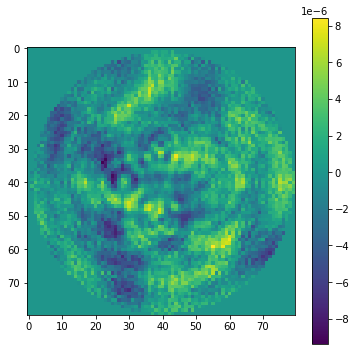

In [617]:
plt.imshow(grad_loss_func(x0_cg, thetas, data).reshape([nx,nx])); plt.colorbar()

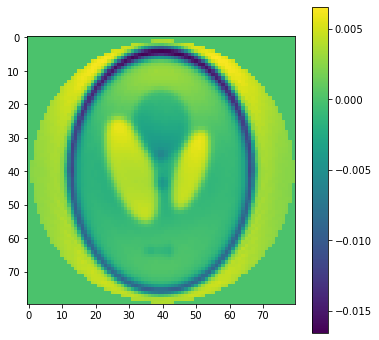

In [618]:
plt.imshow(grad_loss_func(x0, thetas, data).reshape([nx,nx])); plt.colorbar()

### Randomized block Kaczmarz

In [619]:
key = random.PRNGKey(np.random.randint(1000))

In [690]:
key, subkey = random.split(key)

N_epoch = 10


N_batches = 1000
index_permutations = random.permutation(subkey, N)
block_indices = np.array(np.array_split(index_permutations, N_batches))

x = jnp.zeros(amp.shape)
zero = jnp.zeros((nx**2,))
N_iter_cg = 2
eps_cg = 1e-7

loss_func, grad_loss_func = get_loss_function(fwd_model_vmap)
print(f"{block_indices.shape[0]} iterations/epoch")
     
for ep in range(N_epoch):   
    if ep % 5 == 0:
        print(ep)
        verbose_cg = True

    for i, idx in enumerate(block_indices):
        #if verbose_cg:
        #    print(i)
            
        # Solve the least squares problem to apply the pseudoinverse   
        data_block = -fwd_model_vmap(x, thetas[idx]) + data[idx]

        Ab = -grad_loss_func(zero, thetas[idx], data_block)
        AA = lambda v : grad_loss_func(v, thetas[idx], data_block) + Ab

        x_ls, k = conjugate_gradient(AA, Ab, zero, N_iter_cg, eps = eps_cg, verbose = verbose_cg)

        x = x + x_ls
        
        verbose_cg = False    


1000 iterations/epoch
0
  cg iter 0 ||r|| = 2.0070463418203395
5
  cg iter 0 ||r|| = 0.009455845619358956


In [691]:
rec_gmm = pts2img(x, pts, x_grid, sigma)
rec_gmm = rec_gmm / jnp.max(rec_gmm) * jnp.max(image)

In [692]:
err_gmm = jnp.abs(rec_gmm - image)
print(f"Max error = {jnp.max(err_gmm)}")
print(f"Mean error = {jnp.mean(err_gmm)}")

Max error = 0.09372232801837266
Mean error = 0.008006706627955313


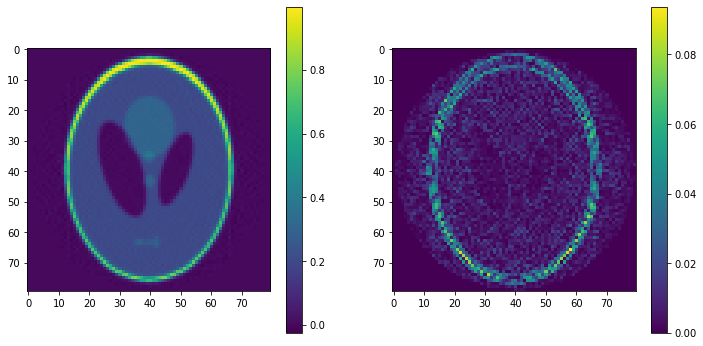

In [693]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm*mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm*mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### Fourier

In [ ]:
img_f = jnp.fft.fft2(jnp.fft.ifftshift(image)) #*jnp.fft.fftshift(mask)
#img_f = img_f.at[0,0].set(0) #

plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar() 

In [ ]:
def rotate_and_project_f(img_f, theta, pts):
    """pts are the Fourier grid points, img_f is the image in Fourier, flattened"""
    
    nx = img_f.shape[0]

    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts_rot = R @ pts.transpose()
    pts_rot = jnp.vstack([pts_rot, jnp.zeros((1,nx*nx))])
    x_grid = np.array([1.0, nx])
    
    idx0 = nx*int(nx/2)
    vol = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

    vol = vol.at[:,:,int(nx/2)].set(jnp.fft.fftshift(img_f))
    vol = jnp.fft.ifftshift(vol)
    img = interpolate(pts_rot, x_grid, vol, 'tri')
    
    #print(pts[idx0:idx0+nx,:])

    proj = img[idx0:idx0+nx]
    
    return proj, img, pts

In [ ]:
# Get the Fourier grid
x_grid_f = jnp.arange(-nx/2, nx/2)
X, Y = jnp.meshgrid(x_grid_f, x_grid_f)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

In [ ]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project_f(img_f, theta, pts)

plt.imshow((jnp.abs(img_rot.reshape([nx,nx])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar()

In [ ]:
img_rot_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(img_rot.reshape([nx,nx])))))
plt.imshow(img_rot_r); plt.colorbar()

In [ ]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_f)

N = sinogram.shape[1]
sig_noise = 10000

#thetas = 2 * jnp.pi * jnp.array(np.random.rand(N)) 

data = sinogram.transpose() #fwd_model_vmap(img_f, thetas) 
data_noisy = data + (np.random.randn(N, nx) + 1j*np.random.randn(N, nx))* sig_noise

SNR = jnp.real(jnp.sum(jnp.conj(data)*data)/jnp.sum(jnp.conj(data_noisy)*data_noisy))
print(f"max(data) = {jnp.max(jnp.abs(data))}")
print(f"SNR = {SNR}")

In [ ]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap, thetas, data)

In [ ]:
N_iters = 1000
alpha = 1e-1

x0 = jnp.zeros(img_f.shape, dtype = jnp.complex128)
#x0 = img_f + 1

for i in range(N_iters):
    if jnp.mod(i, 100) == 0:
        err = jnp.abs(img_f-x0).reshape([nx,nx]) * mask

        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad_loss_func(x0)

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(x0))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(x0)))); plt.colorbar()